# Indegrees and edge effect
Here, we consider indegrees and how they are affected by considering only a central subvolume with less of an edge effect.

For a longer explanation what I mean by edge effect, see the notebook "Microns check edge effect" first!

For this exploration, the compressed representation of the connectome suffices, so we load it in "conntility" format.
This package can be installed using:
 > pip install Connectome-Utilities
 
The other packages are standard

In [1]:
import pandas
import numpy
import conntility

fn_mat = "microns_mm3_connectome.h5"
name_dset_f = "full"
name_dset_c = "condensed"

# M = conntility.ConnectivityMatrix.from_h5(fn_mat, name_dset_f)
C = conntility.ConnectivityMatrix.from_h5(fn_mat, name_dset_c)

We plot the distribution of in- and out-degrees of the individual neuron types.
Degrees are expected to be distributed log-normal, so we plot them in log-space.

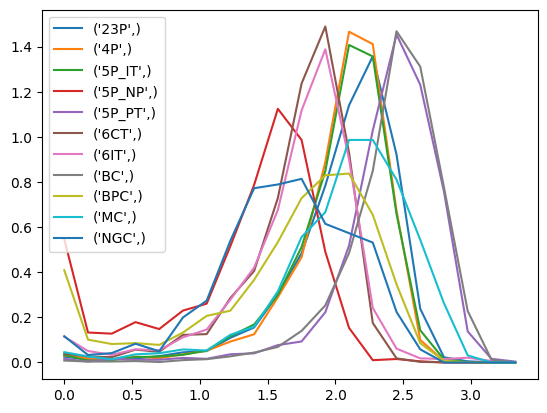

In [3]:
from matplotlib import pyplot as plt


deg_bins = numpy.linspace(0, 3.5, 21)

per_type = C.partition("cell_type")
for type_name, s in zip(per_type.index, per_type):
    H = numpy.histogram(numpy.log10(s.vertices["indegree"] + 1),
                        bins=deg_bins, density=True)[0]
    plt.plot(deg_bins[:-1], H, label=type_name)
plt.legend()

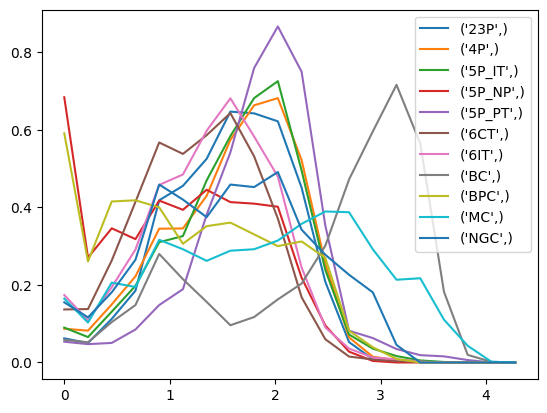

In [4]:
deg_bins = numpy.linspace(0, 4.5, 21)

per_type = C.partition("cell_type")
for type_name, s in zip(per_type.index, per_type):
    H = numpy.histogram(numpy.log10(s.vertices["outdegree"] + 1),
                        bins=deg_bins, density=True)[0]
    plt.plot(deg_bins[:-1], H, label=type_name)
plt.legend()

Distributions are somewhat lognormal, but have additional mass on the left side. I think this may be the edge effect. Again, for an explanation what _exactly_ I mean by that check the notebook mentioned above.

For a more detailed view we consider mean indegrees in a "top-down" view, i.e. projection into the x-z plane.
To that end, we first bin the x and z-coordinates into 51x51 bins, then calculate averages per 2d bin.

We also indicate the location of a possible 300 x 300 um subvolume that is central to the VISp region. It should be less affected by edge effects.

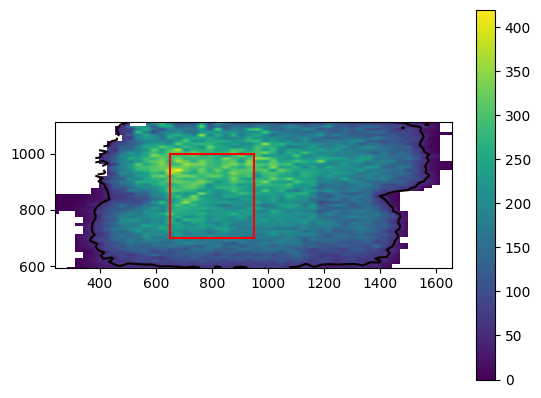

In [6]:
nbins= 51
extents = {}
for col in ["x_nm", "z_nm"]:
    bins = numpy.linspace(C.vertices[col].min(), C.vertices[col].max() + 1, nbins)
    extents[col] = [bins[0] / 1000, bins[-1] / 1000]
    C.add_vertex_property(col + "_binned_{0}".format(nbins),
                        numpy.digitize(C.vertices[col], bins=bins))
    
I = C.vertices.groupby(["x_nm_binned_51",
                        "z_nm_binned_51"])["indegree"].mean().unstack("x_nm_binned_51")

plt.colorbar(plt.imshow(I.values,
            extent=extents["x_nm"] + extents["z_nm"][::-1]))
plt.contour(I.values, cmap="hot", levels=[60.],
           extent=extents["x_nm"] + extents["z_nm"])
plt.gca().set_ylim(plt.gca().get_ylim()[::-1])

interval_x = [650, 950]
interval_z = [700, 1000]

plt.plot(interval_x, [interval_z[0], interval_z[0]], color="red")
plt.plot(interval_x, [interval_z[1], interval_z[1]], color="red")
plt.plot([interval_x[0], interval_x[0]], interval_z, color="red")
plt.plot([interval_x[1], interval_x[1]], interval_z, color="red")

We limit the connectome data to the indicated subvolume.

To that end, we use the .index functionality. In each indexing step, we limit the volume to neuron below (.lt(), i.e. "less than") or above (.gt(), i.e. greater than) a certain coordinate value.

In [7]:
S = C.index("x_nm").gt(interval_x[0] * 1000).index("x_nm").lt(interval_x[1] * 1000)
S = S.index("z_nm").gt(interval_z[0] * 1000).index("z_nm").lt(interval_z[1] * 1000)

Now we plot the degree distribution in the subvolume. Is it more log-normal?

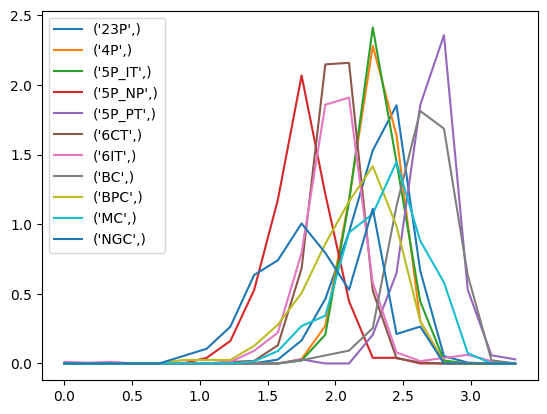

In [8]:
deg_bins = numpy.linspace(0, 3.5, 21)

per_type = S.partition("cell_type")
for type_name, s in zip(per_type.index, per_type):
    H = numpy.histogram(numpy.log10(s.vertices["indegree"] + 1),
                        bins=deg_bins, density=True)[0]
    plt.plot(deg_bins[:-1], H, label=type_name)
plt.legend()

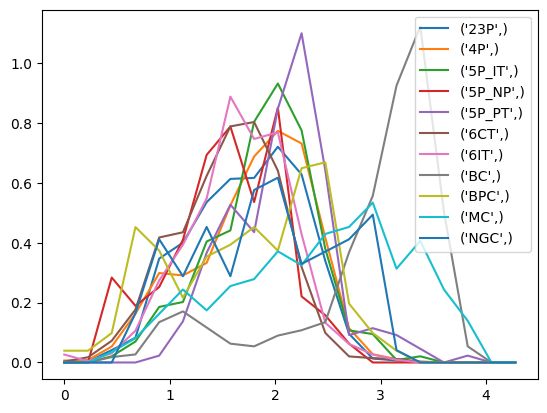

In [9]:
deg_bins = numpy.linspace(0, 4.5, 21)

per_type = S.partition("cell_type")
for type_name, s in zip(per_type.index, per_type):
    H = numpy.histogram(numpy.log10(s.vertices["outdegree"] + 1),
                        bins=deg_bins, density=True)[0]
    plt.plot(deg_bins[:-1], H, label=type_name)
plt.legend()